In [1]:
import pytumblr
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import re
import nltk.data
import logging
from gensim.models import word2vec
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from time import time, sleep

import matplotlib.pyplot as plt
%matplotlib inline

## Tumblr data scraping

In [2]:
# Authenticate via OAuth
client = pytumblr.TumblrRestClient(
  'IfgCzO5vai28fvtoOZqhirNO4Wy4XWDEBAB0iORxfCCxcpqfky',
  'c7NCLElazxRkIUgZw00Ur5lW6qsL2SR8qmVdQ3jyd29RkoeGB3',
  '4z8Ljx4lc2YJkh5rCf6dEWAGs9A4M0Z7EQFL7jVH4AnDBeCd69',
  'JTHBUNxnSoK5VcB7nHipx7rSYbMGilW27DceHVhu9lI0z0Law1'
)

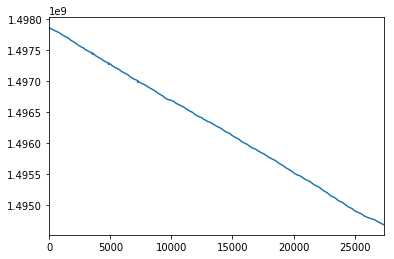

In [7]:
# 6 basic emotions: happiness, sadness, anger, disgust, fear, surprise
# Posts available here: https://www.tumblr.com/tagged/happy
search_query = 'happy'

# Load previously scraped data
df = pd.read_csv('./data/' + search_query + '.csv', encoding='utf-8')
df['timestamp'].plot()

In [4]:
t0 = time()

posts = []
# Continue scraping starting from the oldest timestamp
before = df['timestamp'].min()

# Delta limit in timestamps between two consecutive posts
delta_limit = 3600 * 24 # 24 hours
nb_rejected = 0
timestamps_rejected = []

# 800 requests to avoid exceeding Tumblr API's limitations
for i in range(900):
    tagged = client.tagged(search_query, filter='text', before=before)
    for elt in tagged:
        timestamp = elt['timestamp']
        if (abs(timestamp - before) < delta_limit):
            before = timestamp
            
            current_post = []
            current_post.append(elt['id'])
            current_post.append(elt['post_url'])

            elt_type = elt['type']
            current_post.append(elt_type)
            current_post.append(timestamp)
            current_post.append(elt['date'])
            current_post.append(elt['tags'])
            current_post.append(elt['liked'])
            current_post.append(elt['note_count'])

            if (elt_type == 'photo'):
                # Only take the first image
                current_post.append(elt['photos'][0]['original_size']['url'])
                current_post.append(elt['caption'].replace('\n',' ').replace('\r',' '))
                current_post.append(search_query)
                posts.append(current_post)
            elif (elt_type == 'text'):
                current_post.append(np.nan)
                current_post.append(elt['body'].replace('\n',' ').replace('\r',' '))
                current_post.append(search_query)
                posts.append(current_post)
        else:
            nb_rejected += 1
            timestamps_rejected.append(timestamp)
    
print('Rejected {0} posts'.format(nb_rejected))
print(timestamps_rejected)
print('The scraping took {0}s'.format(time() - t0))

Rejected 117 posts
[1460390447, 1461232841, 1440381002, 1438223217, 1442173559, 1440702894, 1442078776, 1462966029, 1486918810, 1440954636, 1462040674, 1439140104, 1464001297, 1463274027, 1436240684, 1472026055, 1439827214, 1437688853, 1436241072, 1496258349, 1473769460, 1439827214, 1460865240, 1479561998, 1479561998, 1464001297, 1466643892, 1468155147, 1438945201, 1441134049, 1462133331, 1488114394, 1462133331, 1473943720, 1440550667, 1458307782, 1466643892, 1440190764, 1480704225, 1480704225, 1457650835, 1446140918, 1446845719, 1446351638, 1442173559, 1436846675, 1446351638, 1446042073, 1465208662, 1484535329, 1495742705, 1438809446, 1462133331, 1462774502, 1485261055, 1441144886, 1460455204, 1460295074, 1485620174, 1485620174, 1465350921, 1471608119, 1474289672, 1486918810, 1467600451, 1467473341, 1458405484, 1462040674, 1461528409, 1462774502, 1460628008, 1450286053, 1463219562, 1462774502, 1479081178, 1462966029, 1438394339, 1440702894, 1443675259, 1462320046, 1439658445, 14738638

In [5]:
df_posts = pd.DataFrame(posts, columns=['id', 'post_url', 'type', 'timestamp', 'date',
                                        'tags', 'liked', 'note_count', 'photo', 'text', 'search_query'])
df_posts

,id,post_url,type,timestamp,date,tags,liked,note_count,photo,text,search_query
0,161424762170,http://painting--dreams.tumblr.com/post/161424...,photo,1496581114,2017-06-04 12:58:34 GMT,"[happy, quotes, morning, live, sunday, enjoy, ...",False,0,https://68.media.tumblr.com/0bb2b2a83f7c6ca7d7...,"Vive Simple, Be Happy 😊. . . . . . . ....",happy
1,161424761444,http://rozaliafashion.tumblr.com/post/16142476...,photo,1496581113,2017-06-04 12:58:33 GMT,"[instagood, tweegram, happy, bestoftheday, ins...",False,0,https://68.media.tumblr.com/504060c21e4c8232a6...,Czas na relaks ❤️#kraków #charlottebistro #ins...,happy
2,161424757789,https://annascona.tumblr.com/post/161424757789,photo,1496581103,2017-06-04 12:58:23 GMT,"[2017, liebe, love, happy]",False,0,https://68.media.tumblr.com/61748ef12f6cc5f859...,,happy
3,161424747867,https://irish-nude-model-rebequah-rose.tumblr....,photo,1496581073,2017-06-04 12:57:53 GMT,"[sunnyafternoon, happy, hippie, portraitphotog...",False,4,https://68.media.tumblr.com/f407bc731d05faa1a5...,#foresting for mushrooms🍄 #naturalthings #su...,happy
4,161424746071,https://cccchannel.tumblr.com/post/16142474607...,photo,1496581070,2017-06-04 12:57:50 GMT,"[russia, lol, epic, happy, me, friends, joke, ...",False,0,https://68.media.tumblr.com/8ff5c87ae2835e4be2...,"™ CRY COMEDY CHANNEL Welcome, friends. Subsc...",happy
5,161424638300,https://monsterhippie.tumblr.com/post/16142463...,photo,1496580780,2017-06-04 12:53:00 GMT,"[love, today, twitter, instagram, happy, photo...",False,0,https://68.media.tumblr.com/62c9dd5da81321b189...,Be a dude or be rude. #live #life #laugh #le...,happy
6,161424565698,http://charitajones.tumblr.com/post/1614245656...,photo,1496580583,2017-06-04 12:49:43 GMT,"[makeadifference, bethechange, happy, joy, sun...",False,0,https://68.media.tumblr.com/f167cbc14978fb8f5e...,BE HAPPY!!! ❤ #waytogo #happiness #behappy #l...,happy
7,161424538550,https://positive-memes.tumblr.com/post/1614245...,photo,1496580519,2017-06-04 12:48:39 GMT,"[wholesome, funny, happy, positive thoughts]",False,67,https://68.media.tumblr.com/de288aa644d95f0504...,Mums are the best,happy
8,161424538315,https://positive-memes.tumblr.com/post/1614245...,photo,1496580518,2017-06-04 12:48:38 GMT,"[wholesome, funny, happy, positive thoughts]",False,61,https://68.media.tumblr.com/df255696c4a86378bd...,The amount of love on this blog,happy
9,161424529355,https://thefunbox.tumblr.com/post/161424529355...,photo,1496580493,2017-06-04 12:48:13 GMT,"[fun, funny, happy, memes]",False,1,https://68.media.tumblr.com/de288aa644d95f0504...,Mums are the best,happy


In [6]:
# Concatenate and save the new posts
df_concat = pd.concat([df, df_posts]).reset_index(drop=True)
df_concat.to_csv('./data/' + search_query + '.csv', encoding='utf-8', index=False)

## Word2vec

In [56]:
# Convert a sentence for a list of words
def sentence_to_wordlist(review):
    # Remove HTML
    review_text = BeautifulSoup(review).get_text()
    
    # Remove non-letters
    review_text = re.sub('[^a-zA-Z]', ' ', review_text)
    
    # Convert words to lower case and split them
    words = review_text.lower().split()
    
    return words

# Convert a paragraph to a list of list of words
def string_to_sentences(string, tokenizer):
    sentences = []
    # Check for nan text
    if (type(string) == float) and (np.isnan(string)):
        pass
    else:
        raw_sentences = tokenizer.tokenize(string.strip())
        for elt in raw_sentences:
            if (len(elt) > 0):
                sentences.append(sentence_to_wordlist(elt))
            
    return sentences

# Convert a paragraph to a list of words
def string_to_words_weights(string, tokenizer, vocab, vocab_weights):
    sentences = []
    # Check for nan text
    if (type(string) == float) and (np.isnan(string)):
        pass
    else:
        raw_sentences = tokenizer.tokenize(string.strip())
        for elt in raw_sentences:
            if (len(elt) > 0):
                sentences.extend(sentence_to_wordlist(elt))

    words_weights = []
    for elt in sentences:
        if elt in vocab:
            words_weights.append(vocab_weights[elt])

    return np.array(words_weights)

In [99]:
def create_features(X):
    train = X.copy()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    sentences = []

    for text in train['text']:
        sentences += string_to_sentences(text, tokenizer)
        
    # Import the built-in logging module and configure it so that Word2Vec 
    # creates nice output messages
    #logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
     #                   level=logging.INFO)

    # Set values for various parameters
    num_features = 300    # Word vector dimensionality                      
    min_word_count = 40   # Minimum word count                        
    num_workers = 4       # Number of threads to run in parallel
    context = 10          # Context window size                                                                                    
    downsampling = 1e-3   # Downsample setting for frequent words

    # Initialize and train the model (this will take some time)
    print "Training model..."
    model = word2vec.Word2Vec(sentences, workers=num_workers,
                              size=num_features, min_count=min_word_count,
                              window=context, sample=downsampling)

    vocab = set(model.wv.vocab.keys())
    vocab_weights = model.wv

    train['text_list'] = train['text'].map(lambda x: string_to_words_weights(x, tokenizer, vocab, vocab_weights))
    mask = train['text_list'].map(len) > 0
    train_reduced = train.loc[mask, :].reset_index(drop=True)
    return (train_reduced, model)

In [100]:
# Use only 2 emotions first: happiness and sadness
df_happy = pd.read_csv('./data/happy.csv', encoding='utf-8')
df_sad = pd.read_csv('./data/sad.csv', encoding='utf-8')

# Convert a string representation of a list such as '[happy, sun, outdoors]'
# to an actual set of strings {'happy', 'sun', 'outdoors'}
def str_list_to_set(str_list):
    output = str_list[1:-1].split(',')
    output = set([x.strip() for x in output])
    return output

df_happy['tags'] = df_happy['tags'].map(str_list_to_set)
mask_happy = df_happy['tags'].map(lambda x: 'happy' in x)
df_happy = df_happy.loc[mask_happy, :].reset_index(drop=True)

df_sad['tags'] = df_sad['tags'].map(str_list_to_set)
mask_sad = df_sad['tags'].map(lambda x: 'sad' in x)
df_sad = df_sad.loc[mask_sad, :].reset_index(drop=True)

In [101]:
df_all = pd.concat([df_happy, df_sad]).reset_index(drop=True)

In [102]:
train, model = create_features(df_all)

# Binarise emotions
emotion_dict = dict(zip(['happy', 'sad'], [1, 0]))
train['search_query'] =  train['search_query'].map(emotion_dict)

Training model...


## Random Fourier features

In [67]:
n_components = 400
random_seed = 8
rbf = RBFSampler(gamma=1, n_components=n_components, random_state=random_seed)
for i in range(n_components):
    train['rbf_feature_' + str(i)] = 0
rbf_columns = ['rbf_feature_' + str(i) for i in range(n_components)]
train[rbf_columns] = np.vstack(train['text_list'].map(lambda x: rbf.fit_transform(x).mean(axis=0)))

In [134]:
num_features = 300
mean_features = ['mean_feature_' + str(i) for i in range(num_features)]
for col in mean_features:
    train[col] = 0
train[mean_features] = np.vstack(train['text_list'].map(lambda x: x.mean(axis=0)))

## Prediction

In [68]:
X_train, X_test, y_train, y_test = train_test_split(train[rbf_columns], train['search_query'], 
                                                    test_size=0.3, random_state=random_seed)
#forest = RandomForestClassifier(max_depth=15, random_state=random_seed)
#forest.fit(X_train, y_train)
log_reg = LogisticRegression(random_state=random_seed)
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('Train score: {0}'.format(accuracy_score(y_train_pred, y_train)))
print('Test score: {0}'.format(accuracy_score(y_test_pred, y_test)))

Train score: 0.813412765957
Test score: 0.813264495631


In [135]:
# With mean features
X_train, X_test, y_train, y_test = train_test_split(train[mean_features], train['search_query'], 
                                                    test_size=0.3, random_state=random_seed)
#forest = RandomForestClassifier(max_depth=15, random_state=random_seed)
#forest.fit(X_train, y_train)
log_reg = LogisticRegression(random_state=random_seed)
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('Train score: {0}'.format(accuracy_score(y_train_pred, y_train)))
print('Test score: {0}'.format(accuracy_score(y_test_pred, y_test)))

Train score: 0.830774468085
Test score: 0.828196981732


In [198]:
top_coefs = sorted(zip(log_reg.coef_.reshape(-1), np.arange(num_features, dtype=int)), reverse=False)[:20]
top_coefs_indices = [x[1] for x in top_coefs]
top_coefs

[(-3.6729528389741088, 207),
 (-3.1403394958313595, 2),
 (-3.1397062694927818, 100),
 (-3.0588887922961661, 287),
 (-3.0357682613793515, 48),
 (-2.9954608634819686, 179),
 (-2.7998990051591788, 126),
 (-2.6641658205718493, 199),
 (-2.6352856279873604, 240),
 (-2.4445814870835081, 205),
 (-2.4155994699230758, 166),
 (-2.4097718335236147, 201),
 (-2.3806994893747624, 118),
 (-2.088951152816299, 33),
 (-2.0080194235690296, 157),
 (-1.993614074121155, 75),
 (-1.9889547919050636, 25),
 (-1.9814817734527161, 1),
 (-1.9694974934270875, 208),
 (-1.9498382071666363, 57)]

In [199]:
def find_k_most_relevant_word(n_col, vocab, model_weights, k):
    max_coefs = [0] * k
    max_words = [''] * k
    for word in vocab:
        coef = model_weights[word][n_col]
        if (coef > max_coefs[0]):
            max_coefs[1:] = max_coefs[:-1]
            max_coefs[0] = coef
            max_words[1:] = max_words[:-1]
            max_words[0] = word

    return max_words

vocab = model.wv.vocab.keys()
model_weights = model.wv

[find_k_most_relevant_word(i, vocab, model_weights, 5) for i in top_coefs_indices]

[[u'are', u're', u'here', u'sorry', u'suicidal'],
 [u'thing', u'every', u'sleep', u'yellow', ''],
 [u't', u'one', u'thing', u'here', u'every'],
 [u'could', u'has', u'they', u'would', u'every'],
 [u'tt', u'gif', u'is', u'has', u'trending'],
 [u'too', u're', u'want', u'hate', u'sleep'],
 [u're', u'one', u'how', u'thing', u'times'],
 [u've', u'boyfriend', u'eyes', u'di', u'would'],
 [u'his', u'sun', u'beach', u'travel', u'music'],
 [u'now', u'would', u'here', u'sleep', u'yellow'],
 [u've', u'back', u'as', u'away', u'before'],
 [u'if', u'how', u'want', u'tell', u'hate'],
 [u're', u'after', u'room', u'nicht', u'blue'],
 [u'sad', u'gif', u'ng', u'kik', u'want'],
 [u'their', u'people', u'they', u'them', u'want'],
 [u'a', u'an', u'any', u'de', u'school'],
 [u's', u'good', u'after', u'every', u'worth'],
 [u'que', u'ich', u'yang', u'l', u'mi'],
 [u'every', u'sleep', u'four', '', ''],
 [u'who', u'if', u'ever', u'worth', u'certain']]

* Compare with NLTK package
* add more emotions https://upload.wikimedia.org/wikipedia/commons/c/ce/Plutchik-wheel.svg
* multiple emotions for structure of emotions